# Experimental Results using warfit-learn

Project page: [pypi.org/project/warfit-learn/](http://pypi.org/project/warfit-learn/)

Import dependencies and configure environment

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn

import warfit_learn

In [0]:
pd.set_option('mode.chained_assignment', None)

Load the IWPC and PathCare datasets

In [0]:
from warfit_learn import datasets
iwpc_data = datasets.load_iwpc()

path_data = pd.read_csv('datasets/RAW/PathCare/PATH-whole.csv')

In [0]:
iwpc_data.shape, path_data.shape

((6256, 68), (8985, 38))

Preprocess the IWPC data in the style of [Ma et a. 2018](https://journals.plos.org/plosone/article/comments?id=10.1371/journal.pone.0205872), and generate an ML-ready version by vectorising categoricals and dropping unused features.

In [0]:
from warfit_learn import preprocessing

iwpc_inspect = preprocessing.clean_iwpc(iwpc_data)
iwpc = preprocessing.prepare_iwpc(iwpc_data, drop_inr=False)
iwpc.shape, iwpc_inspect.shape

((5741, 33), (5741, 70))

Remove the non-therapeutic data from the PathCare dataset and select features

In [0]:
path = path_data[path_data['isInTherapeutic'] == 1].drop(['patientID', 'requestID'], axis='columns')
path.shape

path = path[[
    "sex",
    "dob",
    "aspirin",
    "paracetamol",
    "amiodarone",
    "atrialFibrilation",
    "deepVeinThrombosis",
    "valveReplacement",
    "takenDoseWeek",
    "inr",
]].dropna()


path = pd.concat([path, pd.get_dummies(path['sex'])], axis=1, sort=False)
path.drop(['sex'], axis='columns', inplace=True)

path.head()

,dob,aspirin,paracetamol,amiodarone,atrialFibrilation,deepVeinThrombosis,valveReplacement,takenDoseWeek,inr,F,M
1,1937,0,0,0,1,0,0,45.0,3.0,0,1
5,1935,0,0,0,1,0,0,35.0,2.1,0,1
11,1946,0,0,0,0,0,0,17.5,2.2,1,0
13,1927,0,1,0,1,0,0,22.5,2.7,1,0
20,1961,0,0,0,0,0,0,47.5,2.2,1,0


Have a look at the features and types of both datasets

In [0]:
iwpc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5741 entries, 0 to 6255
Data columns (total 33 columns):
Height (cm)                                     5741 non-null float64
Weight (kg)                                     5741 non-null float64
Amiodarone (Cordarone)                          5741 non-null float64
Carbamazepine (Tegretol)                        5741 non-null float64
Phenytoin (Dilantin)                            5741 non-null float64
Rifampin or Rifampicin                          5741 non-null float64
Current Smoker                                  5741 non-null float64
Therapeutic Dose of Warfarin                    5741 non-null float64
INR on Reported Therapeutic Dose of Warfarin    5741 non-null float64
Race (OMB)_Asian                                5741 non-null uint8
Race (OMB)_Black or African American            5741 non-null uint8
Race (OMB)_Unknown                              5741 non-null uint8
Race (OMB)_White                                5741 non-nu

In [0]:
path.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4621 entries, 1 to 8983
Data columns (total 11 columns):
dob                   4621 non-null int64
aspirin               4621 non-null int64
paracetamol           4621 non-null int64
amiodarone            4621 non-null int64
atrialFibrilation     4621 non-null int64
deepVeinThrombosis    4621 non-null int64
valveReplacement      4621 non-null int64
takenDoseWeek         4621 non-null float64
inr                   4621 non-null float64
F                     4621 non-null uint8
M                     4621 non-null uint8
dtypes: float64(2), int64(7), uint8(2)
memory usage: 370.0 KB


Examine the values and distributions of both datasets

In [0]:
iwpc.describe()

,Height (cm),Weight (kg),Amiodarone (Cordarone),Carbamazepine (Tegretol),Phenytoin (Dilantin),Rifampin or Rifampicin,Current Smoker,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Race (OMB)_Asian,...,CYP2C9 consensus_*1/*2,CYP2C9 consensus_*1/*3,CYP2C9 consensus_*2/*2,CYP2C9 consensus_*2/*3,CYP2C9 consensus_*3/*3,CYP2C9 consensus_Unknown,Imputed VKORC1_A/A,Imputed VKORC1_A/G,Imputed VKORC1_G/G,Imputed VKORC1_Unknown
count,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,...,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000,5741.000000
mean,167.979150,78.794878,0.048772,0.005574,0.004529,0.000697,0.083957,31.967232,2.152263,0.263891,...,0.131510,0.083957,0.010103,0.011845,0.003484,0.022296,0.295245,0.358474,0.328166,0.018115
std,10.581973,22.316584,0.215410,0.074457,0.067150,0.026389,0.277348,16.765840,0.815865,0.440779,...,0.337987,0.277348,0.100012,0.108196,0.058925,0.147657,0.456192,0.479594,0.469586,0.133380
min,124.970000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,160.020000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.020000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,167.640000,76.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,2.340000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,175.790577,90.700000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,2.600000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,202.000000,237.700000,1.000000,1.000000,1.000000,1.000000,1.000000,230.000000,6.100000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
path.describe()

,dob,aspirin,paracetamol,amiodarone,atrialFibrilation,deepVeinThrombosis,valveReplacement,takenDoseWeek,inr,F,M
count,4621.000000,4621.000000,4621.000000,4621.000000,4621.000000,4621.000000,4621.000000,4621.000000,4621.000000,4621.000000,4621.000000
mean,1947.423501,0.017745,0.016447,0.028349,0.433240,0.109717,0.029214,29.627639,2.455897,0.528673,0.471327
std,13.828309,0.132038,0.127199,0.165985,0.495577,0.312570,0.168425,16.039975,0.333768,0.499231,0.499231
min,1917.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.800000,0.000000,0.000000
25%,1937.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.500000,2.200000,0.000000,0.000000
50%,1945.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.500000,2.400000,1.000000,0.000000
75%,1956.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,37.500000,2.700000,1.000000,1.000000
max,2004.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,210.000000,3.900000,1.000000,1.000000


<Figure size 432x288 with 0 Axes>

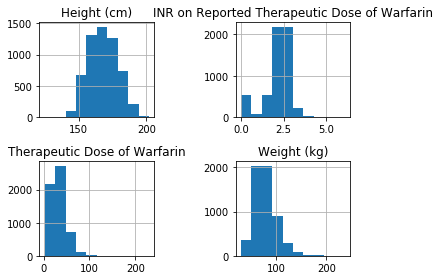

In [0]:
plt.figure()
iwpc[[
    'INR on Reported Therapeutic Dose of Warfarin',
    'Therapeutic Dose of Warfarin',
    'Height (cm)',
    'Weight (kg)',
]].hist()
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

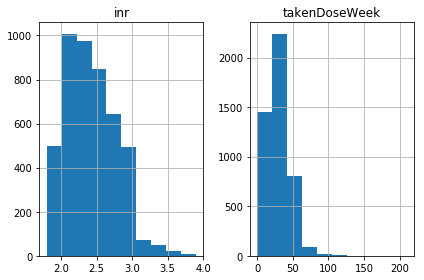

In [0]:
plt.figure()
path[[
    'inr',
    'takenDoseWeek',
]].hist()
plt.tight_layout()
plt.show()

As we can see in both sets of histograms above, the warfarin doses both have skewed distributions. This reduces the performance of predictive models. Similarly to [Ma et al. 2018](https://journals.plos.org/plosone/article/comments?id=10.1371/journal.pone.0205872), we can take the square root of this feature to produce a normal distribution—which we use for training. In evaluation, we can use warfit-learn's evaluation arguments to square the value and produce legitimate predictions for weekly dosage. 

In [0]:
iwpc['Therapeutic Dose of Warfarin'] = iwpc['Therapeutic Dose of Warfarin'].apply(np.sqrt)
path['takenDoseWeek'] = path['takenDoseWeek'].apply(np.sqrt)

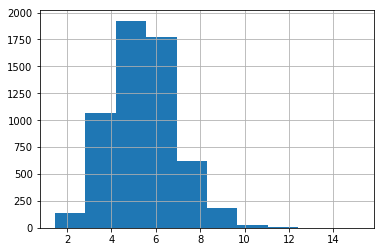

In [0]:
iwpc['Therapeutic Dose of Warfarin'].hist()

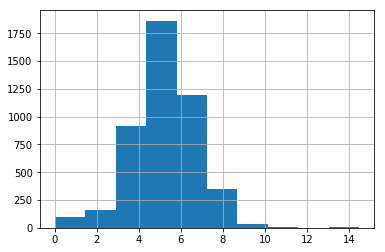

In [0]:
path['takenDoseWeek'].hist()

We can now drop the INR features from both datasets, as they are not features we are training on. We can also drop the dose groups for the IWPC data.

In [0]:
iwpc_raw = iwpc.copy()
iwpc.drop(['INR on Reported Therapeutic Dose of Warfarin'], axis='columns', inplace=True)
path.drop(['inr'], axis='columns', inplace=True)

We can now inspect the fields we will be training on

In [0]:
iwpc.columns

Index(['Height (cm)', 'Weight (kg)', 'Amiodarone (Cordarone)',
       'Carbamazepine (Tegretol)', 'Phenytoin (Dilantin)',
       'Rifampin or Rifampicin', 'Current Smoker',
       'Therapeutic Dose of Warfarin', 'Race (OMB)_Asian',
       'Race (OMB)_Black or African American', 'Race (OMB)_Unknown',
       'Race (OMB)_White', 'Age_10 - 19', 'Age_20 - 29', 'Age_30 - 39',
       'Age_40 - 49', 'Age_50 - 59', 'Age_60 - 69', 'Age_70 - 79',
       'Age_80 - 89', 'Age_90+', 'CYP2C9 consensus_*1/*1',
       'CYP2C9 consensus_*1/*2', 'CYP2C9 consensus_*1/*3',
       'CYP2C9 consensus_*2/*2', 'CYP2C9 consensus_*2/*3',
       'CYP2C9 consensus_*3/*3', 'CYP2C9 consensus_Unknown',
       'Imputed VKORC1_A/A', 'Imputed VKORC1_A/G', 'Imputed VKORC1_G/G',
       'Imputed VKORC1_Unknown'],
      dtype='object')

In [0]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import ChangedBehaviorWarning
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ChangedBehaviorWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

## Evaluation

We now define a collection of sklearn estimators (or ensembles of sklearn estimators) that have been known to perform well on the IWPC data. We then apply them all to the same IWPC dataset, as well as unseen PathCare dataset, and evaluate performance.

In [0]:
from warfit_learn.evaluation import evaluate_estimators

In [0]:
ests = []

We'll add a linear regression baseline first.

In [0]:
from sklearn.linear_model import LinearRegression

ests.append(Estimator(
    LinearRegression(),
    'LR'))

[Liu et al. 2015](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0135784) saw success with off-the-shelf implementations of:

*   Support Vector Regression (SVR)
*   Boosted Regression Trees (BRT)



In [0]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR

ests.append(Estimator(
    LinearSVR(),
    'SVR'))

ests.append(Estimator(
    GradientBoostingRegressor(),
    'BRT'))

Ma et al. 2018 found some of the following to be effective as single estimators:

*   Support Vector Regression (SV)
*   Multiple Linear Regression (MLR)
*   Ridge Regression (RR)


Ma et al. 2018 saw their best results with stacked generalization frameworks:

*   SV at Level-1, with GBT, SV, and NN at Level-0
*   RR at Level-1, with GBT, RR, and NN at Level-0




In [0]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from mlxtend.regressor import StackingCVRegressor


GBT = GradientBoostingRegressor(learning_rate=0.1, loss="lad",
                              max_depth=4,)
RR = Ridge(alpha=1.0)
NN = MLPRegressor(hidden_layer_sizes=(100, ), 
                  activation='logistic', 
                  solver='lbfgs')
SV = SVR(kernel='linear', cache_size=1000)


ests.append(Estimator(SV,'SV'))
ests.append(Estimator(RR, 'RR'))
ests.append(Estimator(GBT, 'GBT'))
ests.append(Estimator(NN, 'NN'))

ests.append(Estimator(
    StackingCVRegressor(
        regressors=[GBT, SV, NN],
        meta_regressor=SV,
        cv=5,
    ),'Stacked_SV'))

ests.append(Estimator(
    StackingCVRegressor(
        regressors=[GBT, RR, NN],
        meta_regressor=RR,
        cv=5,
    ),'Stacked_RR'))

In this study, supervised learning "pipelines" were generated through Genetic Programming. Here we add a few of the best-performers to our list of estimators.

In [0]:
from sklearn.feature_selection import SelectFwe, f_regression, SelectPercentile
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, \
    MinMaxScaler, FunctionTransformer, Normalizer
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoLarsCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, make_union
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_approximation import RBFSampler, Nystroem
from tpot.builtins import StackingEstimator, ZeroCount
from copy import copy


tpot2 = make_pipeline(
    StackingEstimator(
        estimator=LinearSVR(
            C=1.0,
            dual=True,
            epsilon=0.01,
            loss="epsilon_insensitive",
            tol=0.001,)),
    StackingEstimator(
        estimator=ElasticNetCV(l1_ratio=0.6000000000000001, tol=0.01, cv=5)),
    RobustScaler(),
    StackingEstimator(estimator=RidgeCV()),
    ExtraTreesRegressor(
        bootstrap=True,
        max_features=1.0,
        min_samples_leaf=20,
        min_samples_split=2,
        n_estimators=100,)
)

tpot10 = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(
        bootstrap=True, max_features=0.05, 
        min_samples_leaf=18, min_samples_split=10,
        n_estimators=100)),
    MaxAbsScaler(),
    StackingEstimator(estimator=ExtraTreesRegressor(
        bootstrap=True, max_features=0.05,
        min_samples_leaf=18, min_samples_split=10, n_estimators=100)),
    LassoLarsCV(normalize=True, cv=3)
)

tpot17 = make_pipeline(
    make_union(
        FunctionTransformer(copy, validate=True),
        MaxAbsScaler()
    ),
    StackingEstimator(estimator=RidgeCV()),
    ZeroCount(),
    GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, loss="lad",
                              max_depth=3, max_features=0.9000000000000001,
                              min_samples_leaf=20, min_samples_split=8,
                              n_estimators=100, subsample=0.55)
)


# Trained on PathCare data
tpot_06_12 = make_pipeline(
    SelectPercentile(score_func=f_regression, percentile=56),
    MinMaxScaler(),
    RBFSampler(gamma=0.75),
    MinMaxScaler(),
    PCA(iterated_power=2, svd_solver="randomized"),
    PCA(iterated_power=2, svd_solver="randomized"),
    KNeighborsRegressor(n_neighbors=96, p=1, weights="distance")
)

# Trained on PathCare data
tpot_06_12_02 = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        make_union(
            make_pipeline(
                Normalizer(norm="l1"),
                Nystroem(gamma=0.65, kernel="sigmoid", n_components=3),
                SelectFwe(score_func=f_regression, alpha=0.006)
            ),
            make_union(
                FunctionTransformer(copy),
                FunctionTransformer(copy)
            )
        )
    ),
    StackingEstimator(estimator=LinearSVR(C=0.0001, dual=True,
                                          epsilon=0.0001,
                                          loss="epsilon_insensitive",
                                          tol=1e-05)),
    MinMaxScaler(),
    SelectFwe(score_func=f_regression, alpha=0.047),
    Nystroem(gamma=0.9, kernel="polynomial", n_components=6),
    ZeroCount(),
    Nystroem(gamma=0.9500000000000001, kernel="linear", n_components=7),
    KNeighborsRegressor(n_neighbors=99, p=1, weights="distance")
)

# Trained on PathCare data
tpot_06_12_03 = make_pipeline(
    StandardScaler(),
    SelectFwe(score_func=f_regression, alpha=0.047),
    MinMaxScaler(),
    Nystroem(gamma=0.5, kernel="poly", n_components=5),
    StackingEstimator(estimator=DecisionTreeRegressor(
        max_depth=2, min_samples_leaf=12, min_samples_split=5)),
    MaxAbsScaler(),
    SelectFwe(score_func=f_regression, alpha=0.007),
    KNeighborsRegressor(n_neighbors=100, p=1, weights="distance")
)

# Trained on PathCare data (sqrted)
tpot_06_13_02 = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    SelectPercentile(score_func=f_regression, percentile=49),
    MinMaxScaler(),
    RBFSampler(gamma=0.45),
    StackingEstimator(estimator=KNeighborsRegressor(
        n_neighbors=43, p=1, weights="distance")),
    MaxAbsScaler(),
    KNeighborsRegressor(n_neighbors=97, p=1, weights="distance")
)

# Trained on PathCare data (sqrted + not-LITE)
tpot_06_13_01 = make_pipeline(
    SelectFwe(score_func=f_regression, alpha=0.011),
    StackingEstimator(estimator=ElasticNetCV(
        l1_ratio=0.7000000000000001, tol=0.01)),
    MaxAbsScaler(),
    Nystroem(gamma=0.2, kernel="linear", n_components=3),
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=100, p=1, weights="distance")
)

ests.append(Estimator(tpot2, 'TPOT2'))
ests.append(Estimator(tpot10, 'TPOT10'))
ests.append(Estimator(tpot17, 'TPOT17'))
ests.append(Estimator(tpot_06_12, 'TPOT_06_12'))
ests.append(Estimator(tpot_06_12_02, 'TPOT_06_12_02'))
ests.append(Estimator(tpot_06_12_03, 'TPOT_06_12_03'))
ests.append(Estimator(tpot_06_13_01, 'TPOT_06_13_01'))
ests.append(Estimator(tpot_06_13_02, 'TPOT_06_13_02'))

We now evaluate on both datasets for 100 resamplings

In [0]:
iwpc_results = evaluate_estimators(
    ests,
    iwpc,
    target_column='Therapeutic Dose of Warfarin' #@param {type:"string"}
    ,scale=True
    ,resamples = 100 #@param {type:"slider", min:5, max:200, step:1}
    ,test_size=0.2
    ,squaring = True #@param ["True", "False"] {type:"raw"}
    ,technique = 'mccv' #@param ["'bootstrap'", "'mccv'"] {type:"raw"}
    ,parallelism = 0.8 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
)

Using 6 / 8 CPU cores...

LR...
   PW20      MAE        R2
-------  -------  --------
45.9869  8.58826  0.456811

SVR...
   PW20      MAE       R2
-------  -------  -------
46.5648  8.58056  0.45762

BRT...
   PW20      MAE        R2
-------  -------  --------
45.3229  8.74937  0.439686

SV...
   PW20     MAE        R2
-------  ------  --------
46.4108  8.5779  0.458557

RR...
   PW20      MAE        R2
-------  -------  --------
45.9556  8.56863  0.460308

GBT...
   PW20      MAE        R2
-------  -------  --------
46.3098  8.67208  0.433544

NN...
   PW20      MAE        R2
-------  -------  --------
43.1192  9.35923  0.348166

Stacked_SV...
   PW20      MAE        R2
-------  -------  --------
46.3177  8.55151  0.462209

Stacked_RR...
   PW20      MAE        R2
-------  -------  --------
46.0122  8.63365  0.449706

TPOT2...
   PW20      MAE        R2
-------  -------  --------
46.0836  8.56056  0.462155

TPOT10...
   PW20      MAE        R2
-------  -------  --------
46.0322  8.613

In [0]:
path_results = evaluate_estimators(
    ests,
    path,
    target_column='takenDoseWeek' #@param {type:"string"}
    ,scale=True
    ,resamples = 100 #@param {type:"slider", min:5, max:200, step:1}
    ,test_size=0.2
    ,squaring = True #@param ["True", "False"] {type:"raw"}
    ,technique = 'mccv' #@param ["'bootstrap'", "'mccv'"] {type:"raw"}
    ,parallelism = 0.8 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
)

Using 6 / 8 CPU cores...

LR...
   PW20      MAE         R2
-------  -------  ---------
34.0832  10.9774  0.0984202

SVR...
   PW20     MAE        R2
-------  ------  --------
34.4649  10.953  0.113318

BRT...
   PW20      MAE        R2
-------  -------  --------
33.6054  10.9925  0.103892

SV...
   PW20      MAE        R2
-------  -------  --------
34.4032  10.9317  0.109285

RR...
  PW20      MAE         R2
------  -------  ---------
33.987  10.9782  0.0985855

GBT...
  PW20      MAE       R2
------  -------  -------
33.347  10.9889  0.10857

NN...
  PW20      MAE         R2
------  -------  ---------
33.787  11.0686  0.0985458

Stacked_SV...
  PW20      MAE        R2
------  -------  --------
34.453  10.9302  0.115666

Stacked_RR...
   PW20      MAE        R2
-------  -------  --------
33.8346  10.9491  0.108191

TPOT2...
   PW20     MAE       R2
-------  ------  -------
33.5319  11.026  0.10202

TPOT10...
   PW20      MAE         R2
-------  -------  ---------
33.6497  11.0533  0.0

In [0]:
from warfit_learn.metrics import confidence_interval
from scipy.stats import norm

def format_summary(df_res):
    df_summary = df_res.groupby(['Estimator']).mean()
    df_summary.reset_index(inplace=True)
    for alg in df_res['Estimator'].unique():
        for metric in ['PW20', 'MAE', 'R2']:
            lo, hi = confidence_interval(
                df_res[metric][df_res['Estimator'] == alg].values,
            )
            mean = df_res[metric][df_res['Estimator'] == alg].mean()
            
            for v in [mean, lo, hi]:
                if not -10000 < v < 10000:
                    mean, lo, hi = np.nan, np.nan, np.nan
                    
            conf = f"{mean:.2f} ({lo:.2f}–{hi:.2f})"
            df_summary[metric][df_summary['Estimator'] == alg] = conf
            
    return df_summary


In [0]:
iwpc_formatted = format_summary(iwpc_results).drop('R2', axis=1)
path_formatted = format_summary(path_results).drop('R2', axis=1)
df_final = pd.concat([
    iwpc_formatted,
    path_formatted.drop('Estimator', axis=1)
    ], axis=1, keys=['IWPC', 'PathCare'])


In [0]:
df_final

IWPC                                          \
        Estimator                 PW20                MAE   
0             BRT  45.32 (45.04–45.60)   8.75 (8.70–8.80)   
1             GBT  46.31 (46.02–46.60)   8.67 (8.63–8.71)   
2              LR  45.99 (45.75–46.23)   8.59 (8.54–8.64)   
3              NN  43.12 (42.86–43.38)   9.36 (9.31–9.40)   
4              RR  45.96 (45.70–46.21)   8.57 (8.52–8.61)   
5              SV  46.41 (46.16–46.67)   8.58 (8.53–8.62)   
6             SVR  46.56 (46.34–46.79)   8.58 (8.53–8.63)   
7      Stacked_RR  46.01 (45.74–46.28)   8.63 (8.58–8.68)   
8      Stacked_SV  46.32 (46.06–46.57)   8.55 (8.51–8.59)   
9          TPOT10  46.03 (45.76–46.30)   8.61 (8.57–8.66)   
10         TPOT17  46.03 (45.75–46.30)   8.59 (8.54–8.64)   
11          TPOT2  46.08 (45.81–46.35)   8.56 (8.52–8.60)   
12     TPOT_06_12  43.09 (42.83–43.34)   9.38 (9.33–9.43)   
13  TPOT_06_12_02  41.44 (41.11–41.77)   9.59 (9.53–9.65)   
14  TPOT_06_12_03  40.54 (40.15–40.92)  9.96 (9.88–10.04)   
15  TPOT_06_13_01  41.75 (41.39–42.11)   9.64 (9.56–9.72)   
16  TPOT_06_13_02  42.82 (42.56–43.08)   9.43 (9.38–9.48)   

               PathCare                       
                   PW20                  MAE  
0   33.61 (33.32–33.89)  10.99 (10.93–11.05)  
1   33.35 (33.03–33.66)  10.99 (10.92–11.06)  
2   34.08 (33.76–34.40)  10.98 (10.91–11.04)  
3   33.79 (33.48–34.09)  11.07 (11.01–11.13)  
4   33.99 (33.67–34.30)  10.98 (10.92–11.04)  
5   34.40 (34.16–34.65)  10.93 (10.87–10.99)  
6   34.46 (34.16–34.77)  10.95 (10.89–11.01)  
7   33.83 (33.55–34.12)  10.95 (10.89–11.01)  
8   34.45 (34.16–34.75)  10.93 (10.87–10.99)  
9   33.65 (33.37–33.93)  11.05 (11.00–11.11)  
10  33.91 (33.65–34.17)  11.01 (10.95–11.07)  
11  33.53 (33.28–33.78)  11.03 (10.96–11.09)  
12  32.86 (32.58–33.14)  11.29 (11.23–11.35)  
13  32.32 (32.03–32.62)  11.63 (11.56–11.69)  
14  32.37 (32.08–32.66)  11.35 (11.29–11.42)  
15  32.53 (32.25–32.82)  11.39 (11.33–11.45)  
16  32.67 (32.37–32.97)  11.33 (11.27–11.40)

In [0]:
print(df_final.to_latex(index=False, bold_rows=True, na_rep='-'))

\begin{tabular}{lllll}
\toprule
          IWPC & \multicolumn{2}{l}{PathCare} \\
     Estimator &                 PW20 &                MAE &                 PW20 &                  MAE \\
\midrule
           BRT &  45.32 (45.04–45.60) &   8.75 (8.70–8.80) &  33.61 (33.32–33.89) &  10.99 (10.93–11.05) \\
           GBT &  46.31 (46.02–46.60) &   8.67 (8.63–8.71) &  33.35 (33.03–33.66) &  10.99 (10.92–11.06) \\
            LR &  45.99 (45.75–46.23) &   8.59 (8.54–8.64) &  34.08 (33.76–34.40) &  10.98 (10.91–11.04) \\
            NN &  43.12 (42.86–43.38) &   9.36 (9.31–9.40) &  33.79 (33.48–34.09) &  11.07 (11.01–11.13) \\
            RR &  45.96 (45.70–46.21) &   8.57 (8.52–8.61) &  33.99 (33.67–34.30) &  10.98 (10.92–11.04) \\
            SV &  46.41 (46.16–46.67) &   8.58 (8.53–8.62) &  34.40 (34.16–34.65) &  10.93 (10.87–10.99) \\
           SVR &  46.56 (46.34–46.79) &   8.58 (8.53–8.63) &  34.46 (34.16–34.77) &  10.95 (10.89–11.01) \\
    Stacked\_RR &  46.01 (45.74–46.28) &   8.6

Export the raw results for later analysis.

In [0]:
iwpc_results.to_csv('iwpc_results.csv')
path_results.to_csv('path_results.csv')

**Copyright (C) 2019 Gianluca Truda**

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see https://www.gnu.org/licenses/.

